In [51]:
!pip install nasim[dqn] --q
!pip install pyyaml --q


In [55]:
#@title  RL
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import nasim
from pprint import pprint
import yaml

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError as e:
    from gymnasium import error
    raise error.DependencyNotInstalled(
        f"{e}. (HINT: you can install tabular_q_learning_agent dependencies "
        "by running 'pip install nasim[dqn]'.)"
    )


class DoubleQFunction:
    """Double Q-Function with two separate Q-tables to reduce overestimation bias"""

    def __init__(self, num_actions):
        self.q_func1 = dict()
        self.q_func2 = dict()
        self.num_actions = num_actions

    def forward(self, x, use_q1=True):
        if isinstance(x, np.ndarray):
            x = str(x.astype(int))
        if use_q1:
            if x not in self.q_func1:
                self.q_func1[x] = np.zeros(self.num_actions, dtype=np.float32)
            return self.q_func1[x]
        else:
            if x not in self.q_func2:
                self.q_func2[x] = np.zeros(self.num_actions, dtype=np.float32)
            return self.q_func2[x]

    def update(self, s, a, delta, use_q1=True):
        q_vals = self.forward(s, use_q1)
        q_vals[a] += delta

    def get_action(self, x):
        q_vals1 = self.forward(x, use_q1=True)
        q_vals2 = self.forward(x, use_q1=False)
        return int((q_vals1 + q_vals2).argmax())

    def display(self):
        pprint(self.q_func1)
        pprint(self.q_func2)


class PrioritizedReplayBuffer:
    """Experience Replay Buffer with Prioritized Sampling"""

    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha

    def push(self, experience):
        max_priority = max(self.priorities) if self.buffer else 1.0
        self.buffer.append(experience)
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == 0:
            return [], [], [], [], []

        priorities = np.array(self.priorities)
        prob = priorities ** self.alpha
        prob /= prob.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=prob)
        experiences = [self.buffer[i] for i in indices]

        weights = (len(self.buffer) * prob[indices]) ** (-beta)
        weights /= weights.max()

        s_batch, a_batch, r_batch, next_s_batch, done_batch = zip(*experiences)
        return s_batch, a_batch, r_batch, next_s_batch, done_batch, weights, indices

    def update_priorities(self, indices, priorities):
        for i, priority in zip(indices, priorities):
            self.priorities[i] = priority


Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))


class AdvancedQLearningAgent:
    """Advanced Double Q-Learning Agent with Prioritized Experience Replay"""

    def __init__(self, env, seed=None, lr=0.001, training_steps=10000, final_epsilon=0.05,
                 exploration_steps=10000, gamma=0.99, replay_size=100000, batch_size=32,
                 alpha=0.6, beta_start=0.4, beta_frames=100000, verbose=True, **kwargs):
        assert env.flat_actions
        self.verbose = verbose
        if self.verbose:
             None
            #print("\nRunning Advanced Double Q-Learning with config:")
            #pprint(locals())

        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)

        self.env = env
        self.num_actions = self.env.action_space.n
        self.obs_dim = self.env.observation_space.shape

        self.logger = SummaryWriter()

        self.lr = lr
        self.exploration_steps = exploration_steps
        self.final_epsilon = final_epsilon
        self.epsilon_schedule = np.linspace(1.0, self.final_epsilon, self.exploration_steps)
        self.discount = gamma
        self.training_steps = training_steps
        self.steps_done = 0

        self.qfunc = DoubleQFunction(self.num_actions)

        self.replay_buffer = PrioritizedReplayBuffer(replay_size, alpha)
        self.batch_size = batch_size
        self.beta_start = beta_start
        self.beta_frames = beta_frames

        self.episode_rewards = []
        self.network_exploited = False  # Track if the network was exploited

    def get_epsilon(self):
        if self.steps_done < self.exploration_steps:
            return self.epsilon_schedule[self.steps_done]
        return self.final_epsilon

    def beta_by_frame(self, frame_idx):
        return min(1.0, self.beta_start + frame_idx * (1.0 - self.beta_start) / self.beta_frames)

    def get_egreedy_action(self, o, epsilon):
        if random.random() > epsilon:
            return self.qfunc.get_action(o)
        return random.randint(0, self.num_actions - 1)

    def optimize(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return

        beta = self.beta_by_frame(self.steps_done)
        s_batch, a_batch, r_batch, next_s_batch, done_batch, weights, indices = self.replay_buffer.sample(self.batch_size, beta)

        s_batch = np.array(s_batch)
        a_batch = np.array(a_batch)
        r_batch = np.array(r_batch)
        next_s_batch = np.array(next_s_batch)
        done_batch = np.array(done_batch)
        weights = np.array(weights)

        q_vals_next1 = np.array([self.qfunc.forward(s, use_q1=True).max() for s in next_s_batch])
        q_vals_next2 = np.array([self.qfunc.forward(s, use_q1=False).max() for s in next_s_batch])
        q_targets = r_batch + self.discount * np.where(done_batch, 0, np.minimum(q_vals_next1, q_vals_next2))

        current_q_vals = np.array([self.qfunc.forward(s, use_q1=True)[a] for s, a in zip(s_batch, a_batch)])
        deltas = q_targets - current_q_vals

        for i, (s, a, delta) in enumerate(zip(s_batch, a_batch, deltas)):
            self.qfunc.update(s, a, self.lr * delta, use_q1=True)
            self.qfunc.update(s, a, self.lr * delta, use_q1=False)

        self.replay_buffer.update_priorities(indices, abs(deltas))

    def train(self):
        num_episodes = 0
        training_steps_remaining = self.training_steps

        while self.steps_done < self.training_steps:
            self.network_exploited = False  # Reset flag for each episode
            ep_return, ep_steps, goal = self.run_train_episode(training_steps_remaining)
            num_episodes += 1
            training_steps_remaining -= ep_steps

            #print(f"Episode {num_episodes}: Return = {ep_return}, Steps = {ep_steps}, Network Exploited = {self.network_exploited}")

            self.episode_rewards.append(ep_return)

            self.logger.add_scalar("episode", num_episodes, self.steps_done)
            self.logger.add_scalar("epsilon", self.get_epsilon(), self.steps_done)
            self.logger.add_scalar("episode_return", ep_return, self.steps_done)
            self.logger.add_scalar("episode_steps", ep_steps, self.steps_done)
            self.logger.add_scalar("network_exploited", int(self.network_exploited), self.steps_done)

        self.logger.close()
        self.plot_rewards()
        return self.network_exploited

    def run_train_episode(self, step_limit):
        s, _ = self.env.reset()
        done = False
        steps = 0
        episode_return = 0

        while not done and steps < step_limit:
            a = self.get_egreedy_action(s, self.get_epsilon())
            next_s, r, done, _, _ = self.env.step(a)
            self.steps_done += 1

            episode_return += r

            # Check if the network was successfully exploited
            if self.env.goal_reached():
                self.network_exploited = True

            self.replay_buffer.push(Experience(s, a, r, next_s, done))
            self.optimize()

            s = next_s
            steps += 1

        return episode_return, steps, self.env.goal_reached()

    def run_eval_episode(self, env=None, render=False, eval_epsilon=0.05, render_mode="human"):
        if env is None:
            env = self.env

        original_render_mode = env.render_mode
        env.render_mode = render_mode

        s, _ = env.reset()
        done = False
        env_step_limit_reached = False

        steps = 0
        episode_return = 0

        while not done and not env_step_limit_reached:
            a = self.get_egreedy_action(s, eval_epsilon)
            next_s, r, done, env_step_limit_reached, _ = env.step(a)
            s = next_s
            episode_return += r
            steps += 1

            # Check if the network was successfully exploited
            if self.env.goal_reached():
                self.network_exploited = True

        env.render_mode = original_render_mode
        return episode_return, steps, self.env.goal_reached()

    def plot_rewards(self):
        if len(self.episode_rewards) == 0:
            print("No rewards recorded during training.")
            return

        plt.plot(self.episode_rewards)
        plt.title("Rewards Over Episodes")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.show()


def run_advanced_q_learning(network_config_file):
    with open(network_config_file, 'r') as file:
        network_config = yaml.safe_load(file)

    # Initialize environment with network configuration attributes
    env = nasim.load(network_config_file, fully_obs=True, flat_actions=True, flat_obs=True)

    agent = AdvancedQLearningAgent(env)
    agent.train()
    return agent.run_eval_episode(render=False)

In [ ]:
#@title  VS TINY
import os
import yaml
import subprocess
import shutil
import nasim
import time
import random


ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
status = run_advanced_q_learning(network_config_file)
output_value=status[-1]
if output_value in ['False']:
  test_results.append(0)
elif output_value in ['True']:
  test_results.append(1)

unsuccessful_attacks.append(test_results.count(0))
successful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)


print(f"Approach 0 Results - Unsuccessful Attacks: {test_results.count(0)}, Successful Attacks: {test_results.count(1)}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")



#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")
unsuccessful_attacks.append(test.count(0))
successful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 2

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
unsuccessful_attacks.append(test.count(0))
successful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
unsuccessful_attacks.append(test.count(0))
successful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)






In [ ]:

import os
import yaml
import subprocess
import shutil
import nasim
import time
import random
path = '/usr/local/lib/python3.10/dist-packages/nasim/agents/ql_agent.py'
new_path = '/content/x (3).py'
shutil.copy(new_path, path)


#approach 0
path = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
new_path = '/content/1.yaml'
shutil.copy(new_path, path)
ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
for i in range(1):
    # Run the subprocess and capture output
    result = subprocess.run(['python', '-m', 'nasim.agents.ql_agent', 'tiny', '--render_eval'], capture_output=True, text=True)

    # Get the relevant output from the subprocess

    output_value = result.stdout.splitlines()[-3].split()[-1]
    print(output_value)
    if output_value in ['False']:
      test_results.append(0)
    elif output_value in ['True']:
      test_results.append(1)

successful_attacks.append(test_results.count(0))
unsuccessful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)

# Print the final results
print(f"Approach 0 Results: {test_results}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")


#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Run the simulation x times
for i in range(master_number):
    # NetworkEmulator class definition
    class NetworkEmulator:
        def __init__(self, config):
            self.subnets = config['subnets']
            self.topology = config['topology']
            self.sensitive_hosts = config['sensitive_hosts']
            self.os = config['os']
            self.services = config['services']
            self.processes = config['processes']
            self.exploits = config['exploits']
            self.privilege_escalation = config['privilege_escalation']
            self.service_scan_cost = config['service_scan_cost']
            self.os_scan_cost = config['os_scan_cost']
            self.subnet_scan_cost = config['subnet_scan_cost']
            self.process_scan_cost = config['process_scan_cost']
            self.host_configurations = config['host_configurations']
            self.firewall = config['firewall']
            self.step_limit = config['step_limit']
            self.steps = 0
            self.compromised = False

        def scan_services(self, host):
            self.steps += self.service_scan_cost
            return self.host_configurations.get(host, {}).get('services', [])

        def scan_os(self, host):
            self.steps += self.os_scan_cost
            return self.host_configurations.get(host, {}).get('os', '')

        def scan_processes(self, host):
            self.steps += self.process_scan_cost
            return self.host_configurations.get(host, {}).get('processes', [])

        def apply_exploit(self, host, exploit):
            host_os = self.scan_os(host)
            if host_os == exploit['os'] and exploit['service'] in self.scan_services(host):
                if random.random() <= exploit['prob']:
                    return exploit['access']
            return None

        def escalate_privileges(self, host, escalation):
            host_os = self.scan_os(host)
            if host_os == escalation['os'] and escalation['process'] in self.scan_processes(host):
                if random.random() <= escalation['prob']:
                    return escalation['access']
            return None

        def attempt_exploit(self, host, exploit_key):
            exploit = self.exploits[exploit_key]
            access = self.apply_exploit(host, exploit)
            if access == 'user':
                for pe_key in self.privilege_escalation:
                    pe = self.privilege_escalation[pe_key]
                    if pe['access'] == 'root':
                        access = self.escalate_privileges(host, pe)
            return access

        def is_sensitive_host(self, host):
            return host in self.sensitive_hosts

        def start_attack(self, start_host):
            queue = [(start_host, 'none')]
            visited = set()

            while queue and self.steps < self.step_limit:
                current_host, current_access = queue.pop(0)
                if current_host in visited:
                    continue
                visited.add(current_host)

                if self.is_sensitive_host(current_host):
                    self.compromised = True
                    return

                if current_access != 'root':
                    for exploit_key in self.exploits:
                        new_access = self.attempt_exploit(current_host, exploit_key)
                        if new_access:
                            queue.append((current_host, new_access))
                            break

                # Move to connected hosts based on topology
                for i, connected in enumerate(self.topology[current_host[0]]):
                    if connected == 1:
                        for next_host in self.host_configurations:
                            if next_host[0] == i and next_host not in visited:
                                queue.append((next_host, 'none'))

    # Create an instance of NetworkEmulator using the network configuration
    emulator = NetworkEmulator(network_config)
    emulator.start_attack((1, 0))  # Starting attack at host (1, 0)

    # Check if the network was compromised
    if emulator.compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")

successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)

#approach 2

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 4

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 4 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 4 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)



import matplotlib.pyplot as plt

# Mock data for the purposes of plotting
# These would be replaced with actual results from running the approaches
approaches = ['Approach 0', 'Approach 1', 'Approach 2', 'Approach 3', 'Approach 4']






False
Approach 0 Results: [0]
Approach 0 Time Taken: 34.647850036621094 seconds
Approach 1 Results - Unsuccessful Attacks: 1000, Successful Attacks: 0
Approach 1 Time Taken: 0.0677340030670166 seconds
Approach 2 Results - Unsuccessful Attacks: 343, Successful Attacks: 657
Approach 2 Time Taken: 0.05907273292541504 seconds
Approach 3 Results - Unsuccessful Attacks: 0, Successful Attacks: 1000
Approach 3 Time Taken: 0.05938434600830078 seconds
Approach 4 Results - Unsuccessful Attacks: 366, Successful Attacks: 634
Approach 4 Time Taken: 0.048406362533569336 seconds


In [ ]:


import os
import yaml
import subprocess
import shutil
import nasim
import time
import random
path = '/usr/local/lib/python3.10/dist-packages/nasim/agents/ql_agent.py'
new_path = '/content/x (3).py'
shutil.copy(new_path, path)


#approach 0
path = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
new_path = '/content/2.yaml'
shutil.copy(new_path, path)
ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
for i in range(1):
    # Run the subprocess and capture output
    result = subprocess.run(['python', '-m', 'nasim.agents.ql_agent', 'tiny', '--render_eval'], capture_output=True, text=True)

    # Get the relevant output from the subprocess
    output_value = result.stdout.splitlines()[-3].split()[-1]
    print(output_value)
    if output_value in ['False']:
      test_results.append(0)
    elif output_value in ['True']:
      test_results.append(1)

successful_attacks.append(test_results.count(0))
unsuccessful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)

# Print the final results
print(f"Approach 0 Results: {test_results}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")


#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Run the simulation x times
for i in range(master_number):
    # NetworkEmulator class definition
    class NetworkEmulator:
        def __init__(self, config):
            self.subnets = config['subnets']
            self.topology = config['topology']
            self.sensitive_hosts = config['sensitive_hosts']
            self.os = config['os']
            self.services = config['services']
            self.processes = config['processes']
            self.exploits = config['exploits']
            self.privilege_escalation = config['privilege_escalation']
            self.service_scan_cost = config['service_scan_cost']
            self.os_scan_cost = config['os_scan_cost']
            self.subnet_scan_cost = config['subnet_scan_cost']
            self.process_scan_cost = config['process_scan_cost']
            self.host_configurations = config['host_configurations']
            self.firewall = config['firewall']
            self.step_limit = config['step_limit']
            self.steps = 0
            self.compromised = False

        def scan_services(self, host):
            self.steps += self.service_scan_cost
            return self.host_configurations.get(host, {}).get('services', [])

        def scan_os(self, host):
            self.steps += self.os_scan_cost
            return self.host_configurations.get(host, {}).get('os', '')

        def scan_processes(self, host):
            self.steps += self.process_scan_cost
            return self.host_configurations.get(host, {}).get('processes', [])

        def apply_exploit(self, host, exploit):
            host_os = self.scan_os(host)
            if host_os == exploit['os'] and exploit['service'] in self.scan_services(host):
                if random.random() <= exploit['prob']:
                    return exploit['access']
            return None

        def escalate_privileges(self, host, escalation):
            host_os = self.scan_os(host)
            if host_os == escalation['os'] and escalation['process'] in self.scan_processes(host):
                if random.random() <= escalation['prob']:
                    return escalation['access']
            return None

        def attempt_exploit(self, host, exploit_key):
            exploit = self.exploits[exploit_key]
            access = self.apply_exploit(host, exploit)
            if access == 'user':
                for pe_key in self.privilege_escalation:
                    pe = self.privilege_escalation[pe_key]
                    if pe['access'] == 'root':
                        access = self.escalate_privileges(host, pe)
            return access

        def is_sensitive_host(self, host):
            return host in self.sensitive_hosts

        def start_attack(self, start_host):
            queue = [(start_host, 'none')]
            visited = set()

            while queue and self.steps < self.step_limit:
                current_host, current_access = queue.pop(0)
                if current_host in visited:
                    continue
                visited.add(current_host)

                if self.is_sensitive_host(current_host):
                    self.compromised = True
                    return

                if current_access != 'root':
                    for exploit_key in self.exploits:
                        new_access = self.attempt_exploit(current_host, exploit_key)
                        if new_access:
                            queue.append((current_host, new_access))
                            break

                # Move to connected hosts based on topology
                for i, connected in enumerate(self.topology[current_host[0]]):
                    if connected == 1:
                        for next_host in self.host_configurations:
                            if next_host[0] == i and next_host not in visited:
                                queue.append((next_host, 'none'))

    # Create an instance of NetworkEmulator using the network configuration
    emulator = NetworkEmulator(network_config)
    emulator.start_attack((1, 0))  # Starting attack at host (1, 0)

    # Check if the network was compromised
    if emulator.compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")

successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)

#approach 2

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 4

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 4 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 4 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)






False
Approach 0 Results: [0]
Approach 0 Time Taken: 29.498045682907104 seconds
Approach 1 Results - Unsuccessful Attacks: 1000, Successful Attacks: 0
Approach 1 Time Taken: 0.04025554656982422 seconds
Approach 2 Results - Unsuccessful Attacks: 413, Successful Attacks: 587
Approach 2 Time Taken: 0.0429837703704834 seconds
Approach 3 Results - Unsuccessful Attacks: 302, Successful Attacks: 698
Approach 3 Time Taken: 0.03824496269226074 seconds
Approach 4 Results - Unsuccessful Attacks: 392, Successful Attacks: 608
Approach 4 Time Taken: 0.03193926811218262 seconds


In [ ]:


import os
import yaml
import subprocess
import shutil
import nasim
import time
import random
path = '/usr/local/lib/python3.10/dist-packages/nasim/agents/ql_agent.py'
new_path = '/content/x (3).py'
shutil.copy(new_path, path)


#approach 0
path = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
new_path = '/content/3.yaml'
shutil.copy(new_path, path)
ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
for i in range(1):
    # Run the subprocess and capture output
    result = subprocess.run(['python', '-m', 'nasim.agents.ql_agent', 'tiny', '--render_eval'], capture_output=True, text=True)

    # Get the relevant output from the subprocess
    output_value = result.stdout.splitlines()[-3].split()[-1]


    print(output_value)
    if output_value in ['False']:
      test_results.append(0)
    elif output_value in ['True']:
      test_results.append(1)

successful_attacks.append(test_results.count(0))
unsuccessful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)

# Print the final results
print(f"Approach 0 Results: {test_results}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")


#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Run the simulation x times
for i in range(master_number):
    # NetworkEmulator class definition
    class NetworkEmulator:
        def __init__(self, config):
            self.subnets = config['subnets']
            self.topology = config['topology']
            self.sensitive_hosts = config['sensitive_hosts']
            self.os = config['os']
            self.services = config['services']
            self.processes = config['processes']
            self.exploits = config['exploits']
            self.privilege_escalation = config['privilege_escalation']
            self.service_scan_cost = config['service_scan_cost']
            self.os_scan_cost = config['os_scan_cost']
            self.subnet_scan_cost = config['subnet_scan_cost']
            self.process_scan_cost = config['process_scan_cost']
            self.host_configurations = config['host_configurations']
            self.firewall = config['firewall']
            self.step_limit = config['step_limit']
            self.steps = 0
            self.compromised = False

        def scan_services(self, host):
            self.steps += self.service_scan_cost
            return self.host_configurations.get(host, {}).get('services', [])

        def scan_os(self, host):
            self.steps += self.os_scan_cost
            return self.host_configurations.get(host, {}).get('os', '')

        def scan_processes(self, host):
            self.steps += self.process_scan_cost
            return self.host_configurations.get(host, {}).get('processes', [])

        def apply_exploit(self, host, exploit):
            host_os = self.scan_os(host)
            if host_os == exploit['os'] and exploit['service'] in self.scan_services(host):
                if random.random() <= exploit['prob']:
                    return exploit['access']
            return None

        def escalate_privileges(self, host, escalation):
            host_os = self.scan_os(host)
            if host_os == escalation['os'] and escalation['process'] in self.scan_processes(host):
                if random.random() <= escalation['prob']:
                    return escalation['access']
            return None

        def attempt_exploit(self, host, exploit_key):
            exploit = self.exploits[exploit_key]
            access = self.apply_exploit(host, exploit)
            if access == 'user':
                for pe_key in self.privilege_escalation:
                    pe = self.privilege_escalation[pe_key]
                    if pe['access'] == 'root':
                        access = self.escalate_privileges(host, pe)
            return access

        def is_sensitive_host(self, host):
            return host in self.sensitive_hosts

        def start_attack(self, start_host):
            queue = [(start_host, 'none')]
            visited = set()

            while queue and self.steps < self.step_limit:
                current_host, current_access = queue.pop(0)
                if current_host in visited:
                    continue
                visited.add(current_host)

                if self.is_sensitive_host(current_host):
                    self.compromised = True
                    return

                if current_access != 'root':
                    for exploit_key in self.exploits:
                        new_access = self.attempt_exploit(current_host, exploit_key)
                        if new_access:
                            queue.append((current_host, new_access))
                            break

                # Move to connected hosts based on topology
                for i, connected in enumerate(self.topology[current_host[0]]):
                    if connected == 1:
                        for next_host in self.host_configurations:
                            if next_host[0] == i and next_host not in visited:
                                queue.append((next_host, 'none'))

    # Create an instance of NetworkEmulator using the network configuration
    emulator = NetworkEmulator(network_config)
    emulator.start_attack((1, 0))  # Starting attack at host (1, 0)

    # Check if the network was compromised
    if emulator.compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")

successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)

#approach 2

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 4

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 4 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 4 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)



import matplotlib.pyplot as plt

# Mock data for the purposes of plotting
# These would be replaced with actual results from running the approaches
approaches = ['Approach 0', 'Approach 1', 'Approach 2', 'Approach 3', 'Approach 4']







False
Approach 0 Results: [0]
Approach 0 Time Taken: 27.6622371673584 seconds
Approach 1 Results - Unsuccessful Attacks: 1000, Successful Attacks: 0
Approach 1 Time Taken: 0.03441739082336426 seconds
Approach 2 Results - Unsuccessful Attacks: 128, Successful Attacks: 872
Approach 2 Time Taken: 0.03126168251037598 seconds
Approach 3 Results - Unsuccessful Attacks: 0, Successful Attacks: 1000
Approach 3 Time Taken: 0.027014732360839844 seconds
Approach 4 Results - Unsuccessful Attacks: 136, Successful Attacks: 864
Approach 4 Time Taken: 0.025577783584594727 seconds



Running Advanced Double Q-Learning with config:
{'alpha': 0.6,
 'batch_size': 32,
 'beta_frames': 100000,
 'beta_start': 0.4,
 'env': <nasim.envs.environment.NASimEnv object at 0x7897845f8b80>,
 'exploration_steps': 10000,
 'final_epsilon': 0.05,
 'gamma': 0.99,
 'kwargs': {},
 'lr': 0.001,
 'replay_size': 100000,
 'seed': None,
 'self': <__main__.AdvancedQLearningAgent object at 0x7897845f8100>,
 'training_steps': 1000,
 'verbose': True}
Episode 1: Return = 131.0, Steps = 69, Network Exploited = True
Episode 2: Return = 68.0, Steps = 132, Network Exploited = True
Episode 3: Return = 124.0, Steps = 76, Network Exploited = True
Episode 4: Return = 80.0, Steps = 120, Network Exploited = True
Episode 5: Return = 128.0, Steps = 72, Network Exploited = True
Episode 6: Return = 111.0, Steps = 89, Network Exploited = True
Episode 7: Return = 127.0, Steps = 73, Network Exploited = True
Episode 8: Return = 44.0, Steps = 156, Network Exploited = True
Episode 9: Return = 155.0, Steps = 45, Netwo

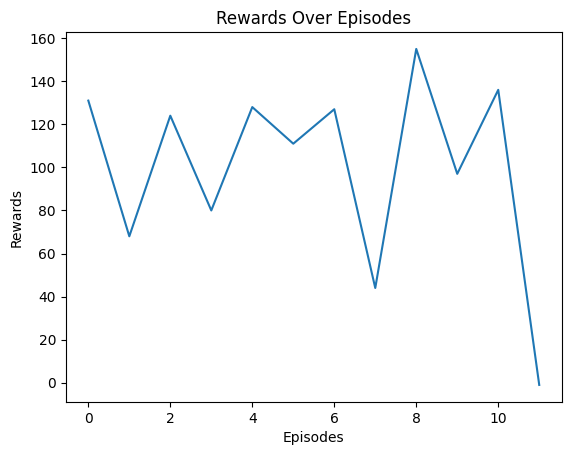

False


In [ ]:

import os
import yaml
import subprocess
import shutil
import nasim
import time
import random
path = '/usr/local/lib/python3.10/dist-packages/nasim/agents/ql_agent.py'
new_path = '/content/x (3).py'
shutil.copy(new_path, path)


#approach 0
path = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
new_path = '/content/5.yaml'
shutil.copy(new_path, path)
ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
for i in range(1):
    # Run the subprocess and capture output
    result = subprocess.run(['python', '-m', 'nasim.agents.ql_agent', 'tiny', '--render_eval'], capture_output=True, text=True)

    # Get the relevant output from the subprocess
    output_value = result.stdout.splitlines()[-3].split()[-1]
    print(output_value)
    if output_value in ['False']:
      test_results.append(0)
    elif output_value in ['True']:
      test_results.append(1)

successful_attacks.append(test_results.count(0))
unsuccessful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)

# Print the final results
print(f"Approach 0 Results: {test_results}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")


#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Run the simulation x times
for i in range(master_number):
    # NetworkEmulator class definition
    class NetworkEmulator:
        def __init__(self, config):
            self.subnets = config['subnets']
            self.topology = config['topology']
            self.sensitive_hosts = config['sensitive_hosts']
            self.os = config['os']
            self.services = config['services']
            self.processes = config['processes']
            self.exploits = config['exploits']
            self.privilege_escalation = config['privilege_escalation']
            self.service_scan_cost = config['service_scan_cost']
            self.os_scan_cost = config['os_scan_cost']
            self.subnet_scan_cost = config['subnet_scan_cost']
            self.process_scan_cost = config['process_scan_cost']
            self.host_configurations = config['host_configurations']
            self.firewall = config['firewall']
            self.step_limit = config['step_limit']
            self.steps = 0
            self.compromised = False

        def scan_services(self, host):
            self.steps += self.service_scan_cost
            return self.host_configurations.get(host, {}).get('services', [])

        def scan_os(self, host):
            self.steps += self.os_scan_cost
            return self.host_configurations.get(host, {}).get('os', '')

        def scan_processes(self, host):
            self.steps += self.process_scan_cost
            return self.host_configurations.get(host, {}).get('processes', [])

        def apply_exploit(self, host, exploit):
            host_os = self.scan_os(host)
            if host_os == exploit['os'] and exploit['service'] in self.scan_services(host):
                if random.random() <= exploit['prob']:
                    return exploit['access']
            return None

        def escalate_privileges(self, host, escalation):
            host_os = self.scan_os(host)
            if host_os == escalation['os'] and escalation['process'] in self.scan_processes(host):
                if random.random() <= escalation['prob']:
                    return escalation['access']
            return None

        def attempt_exploit(self, host, exploit_key):
            exploit = self.exploits[exploit_key]
            access = self.apply_exploit(host, exploit)
            if access == 'user':
                for pe_key in self.privilege_escalation:
                    pe = self.privilege_escalation[pe_key]
                    if pe['access'] == 'root':
                        access = self.escalate_privileges(host, pe)
            return access

        def is_sensitive_host(self, host):
            return host in self.sensitive_hosts

        def start_attack(self, start_host):
            queue = [(start_host, 'none')]
            visited = set()

            while queue and self.steps < self.step_limit:
                current_host, current_access = queue.pop(0)
                if current_host in visited:
                    continue
                visited.add(current_host)

                if self.is_sensitive_host(current_host):
                    self.compromised = True
                    return

                if current_access != 'root':
                    for exploit_key in self.exploits:
                        new_access = self.attempt_exploit(current_host, exploit_key)
                        if new_access:
                            queue.append((current_host, new_access))
                            break

                # Move to connected hosts based on topology
                for i, connected in enumerate(self.topology[current_host[0]]):
                    if connected == 1:
                        for next_host in self.host_configurations:
                            if next_host[0] == i and next_host not in visited:
                                queue.append((next_host, 'none'))

    # Create an instance of NetworkEmulator using the network configuration
    emulator = NetworkEmulator(network_config)
    emulator.start_attack((1, 0))  # Starting attack at host (1, 0)

    # Check if the network was compromised
    if emulator.compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")

successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)

#approach 2

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 4

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 4 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 4 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)






False
Approach 0 Results: [0]
Approach 0 Time Taken: 29.3071711063385 seconds
Approach 1 Results - Unsuccessful Attacks: 1000, Successful Attacks: 0
Approach 1 Time Taken: 0.04144859313964844 seconds
Approach 2 Results - Unsuccessful Attacks: 121, Successful Attacks: 879
Approach 2 Time Taken: 0.026825428009033203 seconds
Approach 3 Results - Unsuccessful Attacks: 0, Successful Attacks: 1000
Approach 3 Time Taken: 0.03388404846191406 seconds
Approach 4 Results - Unsuccessful Attacks: 114, Successful Attacks: 886
Approach 4 Time Taken: 0.026249170303344727 seconds


In [ ]:

import os
import yaml
import subprocess
import shutil
import nasim
import time
import random
path = '/usr/local/lib/python3.10/dist-packages/nasim/agents/ql_agent.py'
new_path = '/content/x (3).py'
shutil.copy(new_path, path)


#approach 0
path = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'
new_path = '/content/6.yaml'
shutil.copy(new_path, path)
ql_agent=[]

master_number = 1000
import subprocess

start_time = time.time()

# List to store the results
test_results = []
successful_attacks=[]
unsuccessful_attacks=[]
time_taken=[]
for i in range(1):
    # Run the subprocess and capture output
    result = subprocess.run(['python', '-m', 'nasim.agents.ql_agent', 'tiny', '--render_eval'], capture_output=True, text=True)

    # Get the relevant output from the subprocess
    output_value = result.stdout.splitlines()[-3].split()[-1]

    print(output_value)
    if output_value in ['False']:
      test_results.append(0)
    elif output_value in ['True']:
      test_results.append(1)

successful_attacks.append(test_results.count(0))
unsuccessful_attacks.append(test_results.count(1))
time_taken.append(time.time() - start_time)

# Print the final results
print(f"Approach 0 Results: {test_results}")
print(f"Approach 0 Time Taken: {time.time() - start_time} seconds")


#approach 1

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Run the simulation x times
for i in range(master_number):
    # NetworkEmulator class definition
    class NetworkEmulator:
        def __init__(self, config):
            self.subnets = config['subnets']
            self.topology = config['topology']
            self.sensitive_hosts = config['sensitive_hosts']
            self.os = config['os']
            self.services = config['services']
            self.processes = config['processes']
            self.exploits = config['exploits']
            self.privilege_escalation = config['privilege_escalation']
            self.service_scan_cost = config['service_scan_cost']
            self.os_scan_cost = config['os_scan_cost']
            self.subnet_scan_cost = config['subnet_scan_cost']
            self.process_scan_cost = config['process_scan_cost']
            self.host_configurations = config['host_configurations']
            self.firewall = config['firewall']
            self.step_limit = config['step_limit']
            self.steps = 0
            self.compromised = False

        def scan_services(self, host):
            self.steps += self.service_scan_cost
            return self.host_configurations.get(host, {}).get('services', [])

        def scan_os(self, host):
            self.steps += self.os_scan_cost
            return self.host_configurations.get(host, {}).get('os', '')

        def scan_processes(self, host):
            self.steps += self.process_scan_cost
            return self.host_configurations.get(host, {}).get('processes', [])

        def apply_exploit(self, host, exploit):
            host_os = self.scan_os(host)
            if host_os == exploit['os'] and exploit['service'] in self.scan_services(host):
                if random.random() <= exploit['prob']:
                    return exploit['access']
            return None

        def escalate_privileges(self, host, escalation):
            host_os = self.scan_os(host)
            if host_os == escalation['os'] and escalation['process'] in self.scan_processes(host):
                if random.random() <= escalation['prob']:
                    return escalation['access']
            return None

        def attempt_exploit(self, host, exploit_key):
            exploit = self.exploits[exploit_key]
            access = self.apply_exploit(host, exploit)
            if access == 'user':
                for pe_key in self.privilege_escalation:
                    pe = self.privilege_escalation[pe_key]
                    if pe['access'] == 'root':
                        access = self.escalate_privileges(host, pe)
            return access

        def is_sensitive_host(self, host):
            return host in self.sensitive_hosts

        def start_attack(self, start_host):
            queue = [(start_host, 'none')]
            visited = set()

            while queue and self.steps < self.step_limit:
                current_host, current_access = queue.pop(0)
                if current_host in visited:
                    continue
                visited.add(current_host)

                if self.is_sensitive_host(current_host):
                    self.compromised = True
                    return

                if current_access != 'root':
                    for exploit_key in self.exploits:
                        new_access = self.attempt_exploit(current_host, exploit_key)
                        if new_access:
                            queue.append((current_host, new_access))
                            break

                # Move to connected hosts based on topology
                for i, connected in enumerate(self.topology[current_host[0]]):
                    if connected == 1:
                        for next_host in self.host_configurations:
                            if next_host[0] == i and next_host not in visited:
                                queue.append((next_host, 'none'))

    # Create an instance of NetworkEmulator using the network configuration
    emulator = NetworkEmulator(network_config)
    emulator.start_attack((1, 0))  # Starting attack at host (1, 0)

    # Check if the network was compromised
    if emulator.compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 1 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 1 Time Taken: {time.time() - start_time} seconds")

successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)

#approach 2

start_time = time.time()

# Load the network configuration from the YAML file
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Test list to keep track of compromised hosts
test = []

# Extract necessary parameters from network configuration
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation_data = network_config['privilege_escalation']  # Renamed to avoid conflict
sensitive_hosts = network_config['sensitive_hosts']
service_scan_cost = network_config['service_scan_cost']
os_scan_cost = network_config['os_scan_cost']
process_scan_cost = network_config['process_scan_cost']
step_limit = network_config['step_limit']

# Run the simulation x times
for i in range(master_number):
    # Variables to track the state of the network and attacks
    compromised_hosts = set()
    compromised = False
    steps = 0

    # Functions for attack simulations
    def service_scan(host):
        global steps
        steps += service_scan_cost
        return host_configurations[host]['services']

    def os_scan(host):
        global steps
        steps += os_scan_cost
        return host_configurations[host]['os']

    def process_scan(host):
        global steps
        steps += process_scan_cost
        return host_configurations[host]['processes']

    def exploit(host, service, os):
        global steps
        exploit = next((e for e in exploits.values() if e['service'] == service and e['os'] == os), None)
        if exploit and random.random() < exploit['prob']:
            steps += exploit['cost']
            return exploit['access']
        return None

    def escalate_privileges(host, process, os):  # Renamed function to avoid conflict
        global steps
        pe = next((p for p in privilege_escalation_data.values() if p['process'] == process and p['os'] == os), None)
        if pe and random.random() < pe['prob']:
            steps += pe['cost']
            return pe['access']
        return None

    # Attack simulation
    for host in host_configurations.keys():
        if steps >= step_limit:
            break

        services = service_scan(host)
        os = os_scan(host)
        processes = process_scan(host)

        for service in services:
            access = exploit(host, service, os)
            if access == 'user':
                compromised_hosts.add((host, access))
                for process in processes:
                    escalated_access = escalate_privileges(host, process, os)
                    if escalated_access == 'root':
                        compromised_hosts.add((host, 'root'))
                        if host in sensitive_hosts:
                            compromised = True
                            break
            if compromised:
                break
        if compromised:
            break

    # Append the result to the test list
    test.append(1 if compromised else 0)

# Print the results
print(f"Approach 2 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 2 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 3

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Costs
service_scan_cost = 1
os_scan_cost = 1
subnet_scan_cost = 1
process_scan_cost = 1

# Helper functions
def scan_services(host):
    return host_configurations[host]['services']

def scan_os(host):
    return host_configurations[host]['os']

def scan_processes(host):
    return host_configurations[host]['processes']

def firewall_allows(host1, host2, service):
    return service in host_configurations.get(host1, {}).get('firewall', {}).get(host2, [])

def attempt_exploit(host, exploit):
    if random.random() <= exploit['prob']:
        return True
    return False

def attempt_privilege_escalation(host, pe):
    if random.random() <= pe['prob']:
        return True
    return False

def compromised(network_map, host):
    return network_map.get(host, {}).get('compromised', False)

def set_compromised(network_map, host, access_level):
    network_map[host] = {'compromised': True, 'access_level': access_level}

# Main attack simulation
def simulate_attack():
    network_map = {}
    attack_log = []

    # Initial compromised hosts as strings based on keys from host_configurations
    initial_hosts = ['(1, 0)', '(2, 0)']  # Using the correct string format for the keys
    for host in initial_hosts:
        set_compromised(network_map, host, 'user')
        attack_log.append(f"Initial compromise: {host}")

    for host in initial_hosts:
        services = scan_services(host)
        os = scan_os(host)
        processes = scan_processes(host)

        for target_host in host_configurations:
            if target_host != host:
                for service in services:
                    if firewall_allows(host, target_host, service):
                        for exploit_name, exploit in exploits.items():
                            if exploit['service'] == service and exploit['os'] == scan_os(target_host):
                                if attempt_exploit(target_host, exploit):
                                    set_compromised(network_map, target_host, exploit['access'])
                                    attack_log.append(f"Exploit {exploit_name} successful on {target_host}")
                                    for pe_name, pe in privilege_escalation.items():
                                        if pe['os'] == scan_os(target_host) and pe['process'] in scan_processes(target_host):
                                            if attempt_privilege_escalation(target_host, pe):
                                                attack_log.append(f"Privilege escalation {pe_name} successful on {target_host}")
                                                set_compromised(network_map, target_host, pe['access'])

    compromised_hosts = [host for host in network_map if network_map[host]['compromised']]
    if any(host in sensitive_hosts for host in compromised_hosts):
        attack_log.append("Network was compromised")
    else:
        attack_log.append("Network was not compromised")

    return attack_log

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):
    attack_log = simulate_attack()
    if attack_log[-1] == "Network was compromised":
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 3 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 3 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)


#approach 4

start_time = time.time()

# Configuration
network_config_file = '/usr/local/lib/python3.10/dist-packages/nasim/scenarios/benchmark/tiny.yaml'

with open(network_config_file, 'r') as file:
    network_config = yaml.safe_load(file)

# Extract configuration details
host_configurations = network_config['host_configurations']
exploits = network_config['exploits']
privilege_escalation = network_config['privilege_escalation']
sensitive_hosts = network_config['sensitive_hosts']

# Test list to keep track of compromised simulations
test = []

# Run the simulation x times
for i in range(master_number):

    # Define a function to attempt an exploit
    def attempt_exploit(exploit, target):
        if random.random() <= exploit['prob']:
            return True
        return False

    # Simulate the attack
    compromised = False
    initial_access = []

    # Start with scanning the network
    for host, config in host_configurations.items():
        for service in config['services']:
            for exploit_name, exploit in exploits.items():
                if exploit['service'] == service and exploit['os'] == config['os']:
                    if attempt_exploit(exploit, host):
                        initial_access.append((host, exploit['access']))
                        break

    # Try privilege escalation
    for access in initial_access:
        host, current_access = access
        if current_access == 'user':
            for pe_name, pe in privilege_escalation.items():
                if pe['process'] in host_configurations[host]['processes'] and pe['os'] == host_configurations[host]['os']:
                    if attempt_exploit(pe, host):
                        current_access = 'root'
                        break

        if current_access == 'root' and host in sensitive_hosts:
            compromised = True
            break

    # Track the result of each simulation
    if compromised:
        test.append(1)
    else:
        test.append(0)

# Print the results
print(f"Approach 4 Results - Unsuccessful Attacks: {test.count(0)}, Successful Attacks: {test.count(1)}")
print(f"Approach 4 Time Taken: {time.time() - start_time} seconds")
successful_attacks.append(test.count(0))
unsuccessful_attacks.append(test.count(1))
time_taken.append(time.time() - start_time)



import matplotlib.pyplot as plt





False
Approach 0 Results: [0]
Approach 0 Time Taken: 30.969379901885986 seconds
Approach 1 Results - Unsuccessful Attacks: 1000, Successful Attacks: 0
Approach 1 Time Taken: 0.039907217025756836 seconds
Approach 2 Results - Unsuccessful Attacks: 198, Successful Attacks: 802
Approach 2 Time Taken: 0.02845931053161621 seconds
Approach 3 Results - Unsuccessful Attacks: 0, Successful Attacks: 1000
Approach 3 Time Taken: 0.03241610527038574 seconds
Approach 4 Results - Unsuccessful Attacks: 194, Successful Attacks: 806
Approach 4 Time Taken: 0.028439998626708984 seconds


In [ ]:
%matplotlib inline


In [ ]:
!pip install nasim[dqn] --q
!pip install pyyaml --q